In [94]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import community
import networkx as nx
import sklearn
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import adjusted_mutual_info_score
import random
from sklearn.metrics import confusion_matrix
from networkx.generators.community import LFR_benchmark_graph

In [95]:
const_rand = 997

In [96]:
def remove_from(
        v, G, color, sum_ins, 
        sum_out, tot_mas, ver_wei):
    
    """
    Remove vertex from community
    v - vertex
    G - adjacency matrix
    color - labels color
    sum_ins - sum of edges inside community
    sum_out - sum of edges outside community
    ver_wei - sum of edges, that are connected to vertices
    """

    
    com_col = color[v]
    k_v = ver_wei[v]
    k_v_in = np.sum(G[v, np.where(color == com_col)])
    sum_ins[com_col] -= k_v_in
    sum_out[com_col] -= (k_v - k_v_in)
    return

In [97]:
def add_to(
        v, to, G, color, sum_ins, 
        sum_out, tot_mas, ver_wei):
    
    """
    Add vertex to community
    v - vertex, that we want to add
    to - vertex, to which community we want to add v
    G - adjacency matrix
    color - labels color
    sum_ins - sum of edges inside community
    sum_out - sum of edges outside community
    tot_mas - sum of all edges
    ver_wei - sum of edges, that are connected to vertices
    """

    com_col = color[to]
    sum_tot = sum_ins[com_col] + sum_out[com_col]
    k_v = ver_wei[v]
    k_v_in = np.sum(G[v, np.where(color == com_col)])
    first = (k_v_in / (2 * tot_mas))
    second = (sum_tot * k_v) / (2 * (tot_mas ** 2))
    add_ans = first - second
    k_v_out = k_v - k_v_in
    return add_ans, k_v_in, k_v_out

In [98]:
def get_best_modularity(
        v, G, color, sum_ins, 
        sum_out, tot_mas, ver_wei, rand_state = const_rand):

    """
    Find to which community we should add v
    v - vertex, that we want to add
    G - adjacency matrix
    color - labels color
    sum_ins - sum of edges inside community
    sum_out - sum of edges outside community
    tot_mas - sum of all edges
    ver_wei - sum of edges, that are connected to vertices
    """
    
    
    help_G = np.nonzero(G[v, :])[0]
    answer = np.zeros(len(help_G))
    if len(help_G) == 0:
        return v, 0, ver_wei[v]
    for i in range(len(help_G)):
        to = help_G[i]
        modularity, k_in, k_out = add_to(
            v, to, G, color, sum_ins, 
            sum_out, tot_mas, ver_wei)
        answer[i] = modularity
    result = np.where(answer == np.amax(answer))
    
    idi = random.randint(0, len(result[0]) - 1)
    
    to = help_G[result[0][idi]]
    mod, k_in, k_out = add_to(
        v, to, G, color, sum_ins, 
        sum_out, tot_mas, ver_wei)
    
    return to, k_in, k_out

In [131]:
def get_separation(
        G, color, sum_ins, sum_out, 
        tot_mas, ver_wei, rand_state = const_rand):

    """
    Find to which community we shuold add all vertices
    v - vertex, that we want to add
    G - adjacency matrix
    color - labels color
    sum_ins - sum of edges inside community
    sum_out - sum of edges outside community
    tot_mas - sum of all edges
    ver_wei - sum of edges, that are connected to vertices
    rand_state - random_state
    """

    random = np.random.RandomState(rand_state)
    rand_order = np.arange(len(G[0]))
    new_ans = np.copy(color)
    random.shuffle(rand_order)
    for i in rand_order:
        remove_from(
            i, G, new_ans, sum_ins, 
            sum_out, tot_mas, ver_wei)
        to, k_in, k_out = get_best_modularity(
            i, G, new_ans, sum_ins, sum_out, 
            tot_mas, ver_wei, rand_state)
        color_to = new_ans[to]
        new_ans[i] = color_to
        sum_ins[color_to] += k_in
        sum_out[color_to] += k_out
    return new_ans

In [132]:
def get_new_level(
        G, color, sum_ins, 
        sum_out, tot_mas, ver_wei, rand_state = const_rand):

    """
    Count best partition
    G - adjacency matrix
    color - labels color
    sum_ins - sum of edges inside community
    sum_out - sum of edges outside community
    tot_mas - sum of all edges
    ver_wei - sum of edges, that are connected to vertices
    rand_state - random_state
    """

    ans = np.copy(color)
    while True:
        new_ans = get_separation(
            G, ans, sum_ins, 
            sum_out, tot_mas, ver_wei, rand_state)
        if np.array_equal(ans, new_ans):
            return ans
        ans = new_ans

In [101]:
def modularity(part, G):
    
    """
    Count of modularity
    part - dictionary of vertex and color
    A - np.array
    """
    
    n = len(G[0])
    degrees = G.sum(axis=1)
    _sum = 0
    m = np.sum(G) / 2
    for i in range(n):
        for j in range(i + 1, n):
            if i == j:
                _sum -= ki * kj / m
            if part[i] == part[j]:
                ki = degrees[i]
                kj = degrees[j]
                _sum += (G[i][j] - ki * kj / (2 * m))
    for i in range(n):
        qwe = degrees[i]
        _sum -= qwe * qwe / (4 * m)
    return _sum / m

In [102]:
def modularity_nx(part, A):
    
    """
    Count of modularity
    part - dictionary of vertex and color
    A - nx.Graph
    """
    
    G = nx.adjacency_matrix(A)
    n = len(part)
    _sum = 0
    m = np.sum(G) / 2
    for i in range(n):
        for j in range(i + 1, n):
            if part[i] == part[j]:
                ki = np.sum(G[i])
                kj = np.sum(G[j])
                _sum += (G[i,j] - ki * kj / (2 * m))
    for i in range(n):
        qwe = np.sum(G[i])
        _sum -= qwe * qwe / (4 * m)
    return _sum / (m)

In [103]:
def make_dict(answer):
    
    """
    Make dictionary form list
    answer - list of colors
    """
    
#     dic = {i: answer[i] for i in range(len(answer))}
    return {i: answer[i] for i in range(len(answer))} #dict(zip(range(len(answer)), answer))

In [104]:
def get_all_levels(G, color, sum_ins, 
        sum_out, tot_mas, ver_wei, rand_state = const_rand):
    
    """
    Count all levels of partition
    G - adjacency matrix
    color - labels color
    sum_ins - sum of edges inside community
    sum_out - sum of edges outside community
    tot_mas - sum of all edges
    ver_wei - sum of edges, that are connected to vertices
    rand_state - random_state
    """
    
    
    answer = get_new_level(
        G, color, sum_ins, 
        sum_out, tot_mas, ver_wei)
    while len(answer) != 1:
        index = {}
        for i in range(len(answer)):
            index[answer[i]] = index.get(answer[i], [])
            index[answer[i]].append(i)
        new_color = np.arange(len(index))
        n = len(new_color)
        
        
        dictionary = {}
        help_d = {}
        idi = 0
        for elem, lis in index.items():
            dictionary[idi] = dictionary.get(idi, lis)
            help_d[elem] = help_d.get(elem, idi)
            idi += 1
        
        new_G = np.zeros((n, n))
        for i in range(len(answer)):
            qwe = np.nonzero(G[i])
            indi = help_d[answer[i]]
            for j in qwe[0]:
                indj = help_d[answer[j]]
                if indi != indj:
                    new_G[indi][indj] += G[i][j]

        new_tot_mas = np.sum(new_G)
        new_sum_out = new_G.sum(axis = 1)
        new_sum_ins = np.zeros(len(new_G))
        new_ver_wei = new_G.sum(axis = 1)
        new_answer = get_new_level(
            new_G, new_color, new_sum_ins, 
            new_sum_out, new_tot_mas, new_ver_wei)
        print(dictionary)
        print()
        print(new_answer)
        print("_________________________")
        answer = new_answer
        color = new_color
        G = new_G
        tot_mas = new_tot_mas
        sum_out = new_sum_out
        sum_ins = new_sum_ins
        ver_wei = new_ver_wei
    
    return  

In [15]:
# input

mats = np.load('E:/Ilnur/Telegram Desktop/adni', allow_pickle=True)
xyz = np.load('E:/Ilnur/Telegram Desktop/adni_centers', allow_pickle=True)

i = 10
coords = xyz[i]
adj = mats[i]
adj += adj.T
np.fill_diagonal(adj, 0)
#n = int(input())
G = adj
color = np.arange(len(adj))

In [16]:
#pre_calc
tot_mas = np.sum(G)
sum_out = G.sum(axis = 1)
sum_ins = np.zeros(len(G))
ver_wei = G.sum(axis = 1)

In [21]:
#answer = get_new_level(
#        G, color, sum_ins, 
#       sum_out, tot_mas, ver_wei)
get_all_levels(G, color, sum_ins, 
       sum_out, tot_mas, ver_wei)
#print(ans)

{0: [0, 3, 4, 5, 6, 7, 9, 11, 13, 14, 19, 23, 27, 31], 1: [1, 2, 10, 12, 15, 16, 17, 18, 20, 21, 22, 24, 25, 26, 30], 2: [8, 28, 29, 32, 33, 42], 3: [34, 36, 40, 47, 49, 50, 51, 52, 54, 56, 57, 61, 62, 63, 66, 67], 4: [35, 44, 46, 55, 58, 59, 60, 64], 5: [37, 38, 39, 41, 43, 45, 48, 53, 65]}

[2 2 2 5 5 5]
_________________________
{0: [0, 1, 2], 1: [3, 4, 5]}

[0 0]
_________________________
{0: [0, 1]}

[0]
_________________________


In [112]:
#Get_ans
mats = np.load('E:/Ilnur/Telegram Desktop/adni', allow_pickle=True)
xyz = np.load('E:/Ilnur/Telegram Desktop/adni_centers', allow_pickle=True)

sum1 = 0
sum2 = 0
for i in range(10):
    coords = xyz[i]
    adj = mats[i]
    adj += adj.T
    np.fill_diagonal(adj, 0)
    
    
    G = adj
    color = np.arange(len(adj))
    
    tot_mas = np.sum(G)
    sum_out = G.sum(axis = 1)
    sum_ins = np.zeros(len(G))
    ver_wei = G.sum(axis = 1)
    answer = get_new_level(
        G, color, sum_ins, 
        sum_out, tot_mas, ver_wei, 997)
    
    g = nx.Graph(adj)
    
    partition = community.best_partition(g, random_state = 997)
    my_partition = make_dict(answer)
    
    color1 = list(partition.values())
    C = confusion_matrix(color1, answer)
    
    
#print(answer)
    
    sum1 += sklearn.metrics.adjusted_rand_score(color1, answer)
    sum2 += sklearn.metrics.adjusted_mutual_info_score(color1, answer)
print()
print(sum1 / 10, sum2 / 10)
#color1 = list(partition.values())
#print(color1)
#sklearn.metrics.adjusted_rand_score(color1, answer)
#sklearn.metrics.adjusted_mutual_info_score(answer, color1)


0.6763711420875687 0.7946554438425222


In [133]:
import matplotlib.pyplot as plt

n = [250, 500]
tau1 = 3
tau2 = 1.1
mu = 0.1
M = LFR_benchmark_graph(n[0], tau1, tau2, mu, average_degree=10,
                        max_degree = 20, min_community=10, max_community = 20, seed=10)

gg=M.copy()   #Here I want to copy
#nx.drawing.draw(M)
adj = nx.to_numpy_matrix(M)
adj = np.array(adj)
adj += adj.T
np.fill_diagonal(adj, 0)

G = adj
color = np.arange(len(adj))

tot_mas = np.sum(G)
sum_out = G.sum(axis = 1)
sum_ins = np.zeros(len(G))
ver_wei = G.sum(axis = 1)


answer = get_new_level(
    G, color, sum_ins, 
    sum_out, tot_mas, ver_wei, 997)
g = nx.Graph(adj)

partition = community.best_partition(g, random_state = 997)
my_partition = make_dict(answer)

color1 = list(partition.values())

print(sklearn.metrics.adjusted_rand_score(color1, answer))

print(sklearn.metrics.adjusted_mutual_info_score(color1, answer))

1.0
1.0


In [14]:
print(C)

[[ 0  0  0  0  0  0  0  0 12  0  0  0  0]
 [ 0  0  0  0  0  0 14  0  0  0  0  0  0]
 [ 0  0  0  0  0  4  0  2  0  5  0  0  0]
 [ 0  0  0  0  0  0  4  0  0  0  0  3 11]
 [ 0  0  0  0  0  0  0  0  0  0 13  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0]]


In [16]:
np.unique(color1, return_counts = True)

(array([0, 1, 2, 3, 4]), array([12, 14, 11, 18, 13], dtype=int64))

In [17]:
np.unique(answer, return_counts = True)

(array([19, 26, 27, 28, 42, 43, 55, 56]),
 array([ 4, 18,  2, 12,  5, 13,  3, 11], dtype=int64))

In [27]:
answer2 = []
n_unique = np.unique(answer)
d = dict(zip(n_unique, range(n_unique.shape[0])))
answer2 = np.array(list(map(lambda x: d[x], answer)))

In [30]:
C = confusion_matrix(color1, answer2)

In [34]:
C2 = C.copy()
C

array([[ 0,  0,  0, 12,  0,  0,  0,  0],
       [ 0, 14,  0,  0,  0,  0,  0,  0],
       [ 4,  0,  2,  0,  5,  0,  0,  0],
       [ 0,  4,  0,  0,  0,  0,  3, 11],
       [ 0,  0,  0,  0,  0, 13,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0]], dtype=int64)

In [38]:
import networkx as nx

In [40]:
g = nx.stochastic_block_model([20, 30, 40], [[0.8, 0.1, 0.1],
                                             [0.1, 0.8, 0.1],
                                             [0.1, 0.1, 0.8]])

In [61]:
np.random.rand(90,90)

array([[0.43586223, 0.44780185, 0.06349421, ..., 0.55373999, 0.83135245,
        0.05778363],
       [0.12399408, 0.59430054, 0.87452945, ..., 0.84684554, 0.28871175,
        0.74147655],
       [0.55131463, 0.26038623, 0.77837058, ..., 0.32977067, 0.62354745,
        0.94009047],
       ...,
       [0.04646777, 0.18745794, 0.18773045, ..., 0.15186797, 0.45425233,
        0.73288014],
       [0.98173457, 0.8840488 , 0.31347957, ..., 0.49603307, 0.06129709,
        0.74826775],
       [0.87517788, 0.8423505 , 0.63277374, ..., 0.02304056, 0.48758048,
        0.43422103]])

In [63]:
adj = np.array(nx.adj_matrix(g).todense())
adj =adj + 0.1*np.random.rand(90,90)

In [65]:
adj

array([[0.04045282, 1.05391727, 1.00735041, ..., 0.04580142, 0.03374904,
        0.00559859],
       [1.01013928, 0.02288404, 1.0342067 , ..., 1.00542638, 0.02248267,
        0.01397926],
       [1.07498563, 1.01673279, 0.08282855, ..., 0.01904503, 1.02104782,
        0.07844357],
       ...,
       [0.09258991, 1.01886912, 0.04432465, ..., 0.06757159, 1.07782873,
        1.09354458],
       [0.01749455, 0.07656654, 1.07266622, ..., 1.01658056, 0.0075489 ,
        1.0041166 ],
       [0.00157837, 0.08199076, 0.0971434 , ..., 1.06285127, 1.0310641 ,
        0.05573484]])

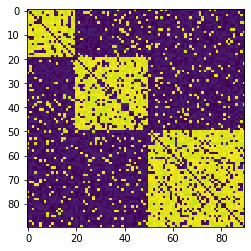

In [66]:
plt.imshow(adj)

In [67]:
sum1 = 0
sum2 = 0
adj += adj.T
np.fill_diagonal(adj, 0)
G = adj
color = np.arange(len(adj))

tot_mas = np.sum(G)
sum_out = G.sum(axis = 1)
sum_ins = np.zeros(len(G))
ver_wei = G.sum(axis = 1)
Q = 0
answer = get_new_level(
    G, color, sum_ins, 
    sum_out, tot_mas, ver_wei, 997)

g = nx.Graph(adj)
partition = community.best_partition(g, random_state = 997)
#print(Q, community.modularity(partition, g))
color1 = list(partition.values())
C = confusion_matrix(color1, answer)


#print(answer)

sum1 += sklearn.metrics.adjusted_rand_score(color1, answer)
sum2 += sklearn.metrics.adjusted_mutual_info_score(color1, answer)

print(sum1, sum2)

1.0 1.0


In [9]:
mats.shape

(807, 68, 68)

In [10]:
def mod(A, p):
    d = A.sum(axis=1)
    n = A.shape[0]
    total = 0
    m = A.sum()
    for i in range(n):
        for j in range(i, n):
            if p[i] == p[j]:
                total += (A[i,j] - d[i]* d[j] / m)
    return total / m

In [11]:
partition

{0: 0,
 1: 1,
 2: 1,
 3: 2,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 8: 2,
 9: 0,
 10: 1,
 11: 2,
 12: 1,
 13: 0,
 14: 2,
 15: 3,
 16: 1,
 17: 1,
 18: 1,
 19: 2,
 20: 1,
 21: 1,
 22: 1,
 23: 2,
 24: 1,
 25: 1,
 26: 1,
 27: 2,
 28: 0,
 29: 0,
 30: 1,
 31: 0,
 32: 0,
 33: 0,
 34: 4,
 35: 3,
 36: 3,
 37: 2,
 38: 4,
 39: 4,
 40: 4,
 41: 4,
 42: 2,
 43: 4,
 44: 3,
 45: 4,
 46: 3,
 47: 4,
 48: 4,
 49: 3,
 50: 3,
 51: 3,
 52: 3,
 53: 4,
 54: 3,
 55: 3,
 56: 3,
 57: 2,
 58: 3,
 59: 3,
 60: 3,
 61: 2,
 62: 4,
 63: 3,
 64: 3,
 65: 4,
 66: 4,
 67: 3}

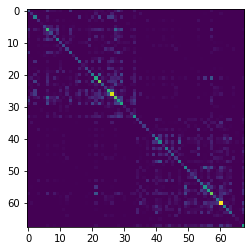

In [7]:
plt.imshow(mats[10])

In [149]:
g = nx.Graph(adj)
partition = community.best_partition(g)
color1 = list(partition.values())
print(color1)
sklearn.metrics.adjusted_mutual_info_score(color1, answer)

[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 2, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 3, 2, 2, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 2, 3, 2, 2, 2, 2, 3, 3, 3, 2, 3, 3, 3]


0.6111290037008896

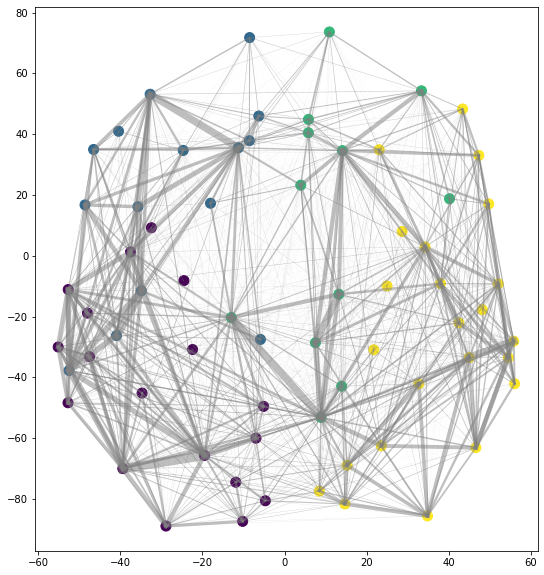

In [150]:
plt.figure(figsize=(9,10))
plt.scatter(coords[:, 0], coords[:, 1], s=100, c=color1)
for x in range(68):
    for y in range(x, 68):
        plt.plot([coords[x, 0], coords[y, 0]], [coords[x, 1], coords[y, 1]],
                 lw = .001*adj[x, y], alpha=.5, c='gray')

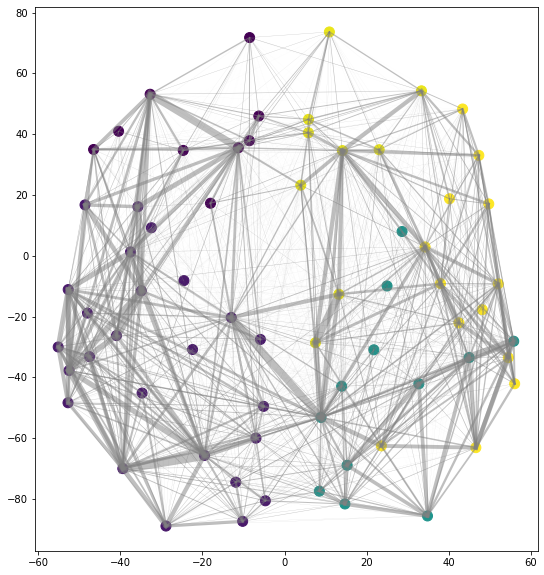

In [151]:
plt.figure(figsize=(9,10))
plt.scatter(coords[:, 0], coords[:, 1], s=100, c=answer)
for x in range(68):
    for y in range(x, 68):
        plt.plot([coords[x, 0], coords[y, 0]], [coords[x, 1], coords[y, 1]],
                 lw = .001*adj[x, y], alpha=.5, c='gray')